From tutorial: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from methods import *

# Choice of Model to Attack
- LeNet5: MNIST
- Basic CNN: Fashion MNIST
- ResNet20: CIFAR-10
### Run **ONE** of the following 3 cells

In [2]:
from models.LeNet import *
target_mdl = LeNet("models/lenet_mnist_model.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

In [2]:
from models.simple_FashionMNIST import *
target_mdl = simple_FashionMNIST("models/simple_FashionMNIST.pth")
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Running on cpu.
Model weights loaded successfully


In [2]:
from models.resNet import ResNet20
target_mdl = ResNet20()
model = target_mdl.model
device = target_mdl.device
test_loader = target_mdl.testloader

Using cache found in C:\Users\JIC/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


# Get baseline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


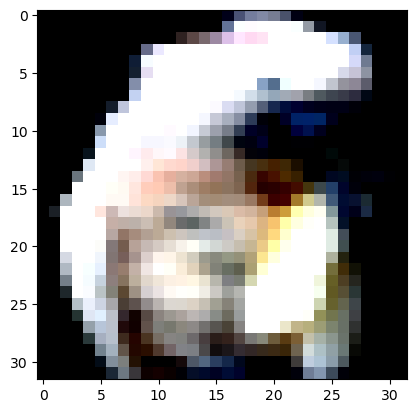

In [8]:
conf_mat = np.zeros((target_mdl.num_classes, target_mdl.num_classes))
i = 0
num_ex = 100
for image, target in target_mdl.testloader:
    #print(image.shape)
    #print(torch.min(image), torch.max(image))
    img = image.squeeze().numpy()
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)#torch.argmax(outputs).item()
    #print(out_idx, target)
    conf_mat[predicted, target] += 1
    i +=1
    if i >= num_ex:
        break
plt.imshow(np.transpose(img/2 +0.5, (1, 2, 0)))

In [3]:
accuracies = []
examples = []
fw_iters = [5]
eps = 0.005
adv_examples = []
hist = None
# Run test for each epsilon
#for eps in epsilons:
for num_fw_iter in fw_iters:
    acc, ex, hist = test_fw(target_mdl, device, eps, num_fw_iter, method='fw', early_stopping='gap_FW', fw_stepsize_rule='ls', gap_FW_tol=0.1)
    accuracies.append(acc)
    examples.append(ex)
final_hist = hist.groupby('example_idx').tail(1) # hist with just the rows of last FW iters
hist

ValueError: not enough values to unpack (expected 3, got 2)

In [4]:
hist.groupby('step').size()

step
AS    1624
FW    3481
dtype: int64

In [5]:
hist[hist['step']=='AS'].groupby('S_idx').size()

S_idx
0     929
1     182
2     187
3     102
4      71
5      45
6      32
7      23
8      13
9      10
10      9
11      9
12      8
13      3
14      1
dtype: int64

In [6]:
final_hist.groupby('stop_cond').size()

stop_cond
gap         822
max_iter    105
dtype: int64

In [7]:
final_hist.groupby('success')['gap_FW'].mean()

success
False    0.726265
True     0.016554
Name: gap_FW, dtype: float64

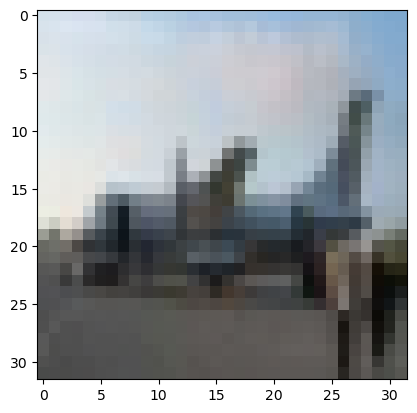

In [31]:
plt.imshow(np.transpose(ex[3][2], (1, 2, 0)))

<Axes: xlabel='FW_iter'>

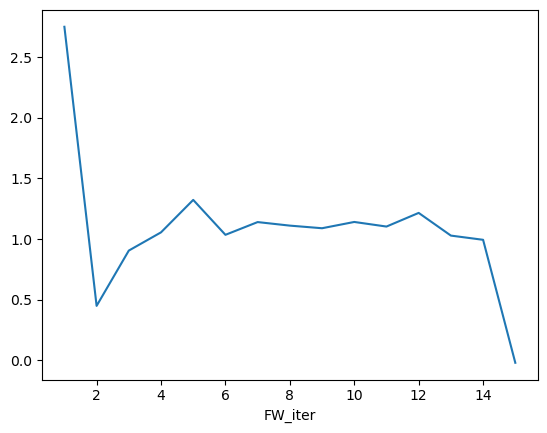

In [20]:
hist[hist['example_idx'].isin(final_hist[(final_hist['success'] == True) & (final_hist['stop_cond'] == 'gap')]['example_idx'])].groupby('FW_iter')['gap_FW'].mean().plot()

<Axes: xlabel='FW_iter'>

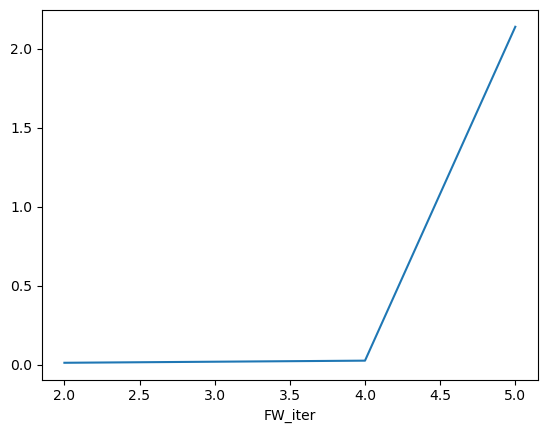

In [5]:
final_hist.groupby('FW_iter')['gap_FW'].mean().plot()

In [11]:
hist.groupby('example_idx').size()

example_idx
0      2
1      2
2      4
3      2
4      7
      ..
995    3
996    3
997    2
998    2
999    2
Length: 927, dtype: int64

Mean FW iterations: 5.5070118662351675


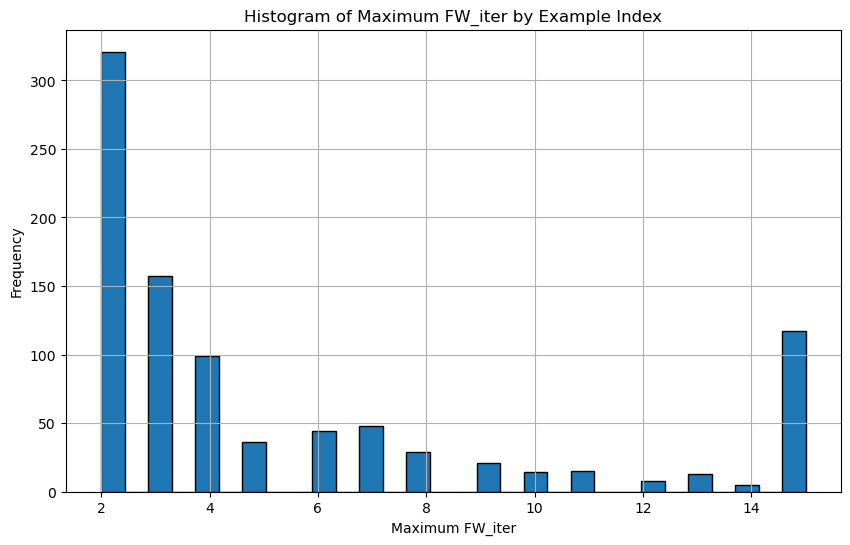

In [12]:
num_iters = hist.groupby('example_idx')['FW_iter'].max()
print(f"Mean FW iterations: {num_iters.mean()}")
plt.figure(figsize=(10, 6))
num_iters.plot(kind='hist', bins=30, edgecolor='black')
plt.title('Histogram of Maximum FW_iter by Example Index')
plt.xlabel('Maximum FW_iter')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [57]:
hist['S_idx'].unique()

array([-1,  0], dtype=int64)

In [75]:
hist.groupby('step').size()

step
AS      56
FW    5187
dtype: int64

In [34]:
# accuracy
hist.groupby('example_idx')['first_success'].sum().mean()

0.12874583795782463

In [35]:
# average number of iterations for success
hist[hist['first_success']]['FW_iter'].mean()

1.0

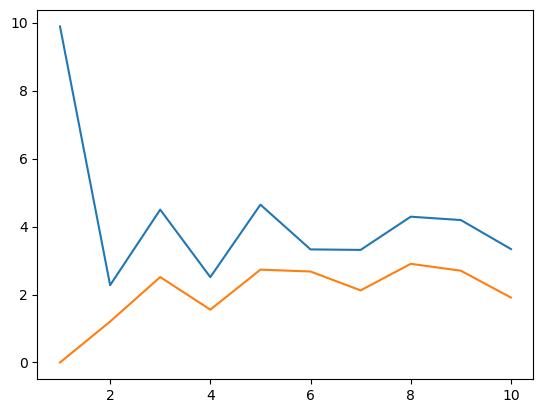

In [72]:
plt.plot(hist[hist['first_success']].groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist[hist['first_success']].groupby('FW_iter')['gap_AS'].mean())

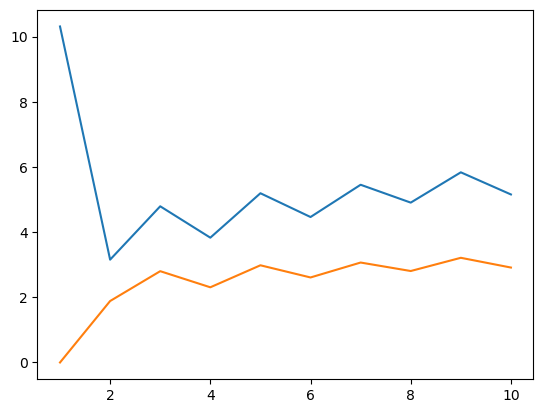

In [74]:
plt.plot(hist.groupby('FW_iter')['gap_FW'].mean())
plt.plot(hist.groupby('FW_iter')['gap_AS'].mean())

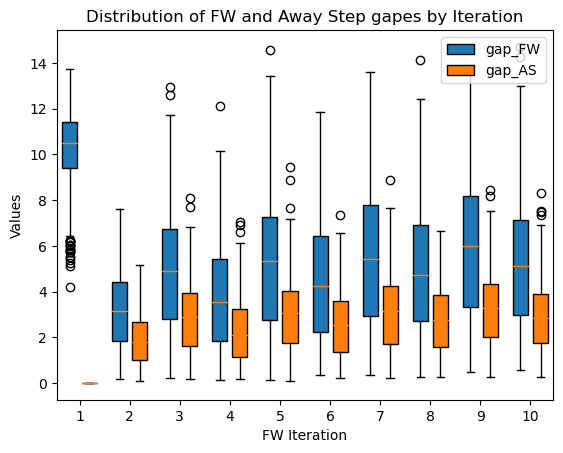

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data generation for demonstration purposes

# Extracting unique iteration groups
groups = hist['FW_iter'].unique()

# Creating lists to hold data for each group
data_FW = []
data_AS = []

for group in groups:
    data_FW.append(hist[hist['FW_iter'] == group]['gap_FW'].values)
    data_AS.append(hist[hist['FW_iter'] == group]['gap_AS'].values)

# Plotting
fig, ax = plt.subplots()

# Positions of the boxplots
positions_FW = np.arange(1, len(groups) + 1) * 2.0 - 0.4
positions_AS = np.arange(1, len(groups) + 1) * 2.0 + 0.4

# Creating the boxplots
box_FW = ax.boxplot(data_FW, positions=positions_FW, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C0"))
box_AS = ax.boxplot(data_AS, positions=positions_AS, widths=0.6, patch_artist=True, boxprops=dict(facecolor="C1"))

# Customizing the plot
ax.set_xlabel('FW Iteration')
ax.set_ylabel('Values')
ax.set_title('Distribution of FW and Away Step gapes by Iteration')
ax.set_xticks(np.arange(1, len(groups) + 1) * 2.0)
ax.set_xticklabels([i for i in groups])

# Adding legend
ax.legend([box_FW["boxes"][0], box_AS["boxes"][0]], ['gap_FW', 'gap_AS'], loc='upper right')

# Display the plot
plt.show()


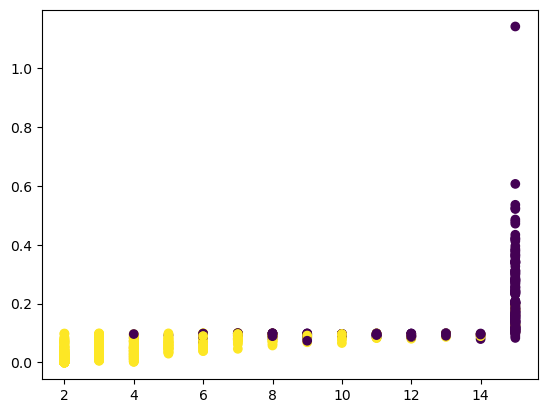

In [35]:
plt.scatter(final_hist['FW_iter'],final_hist['gap_FW'], c=final_hist['success'])

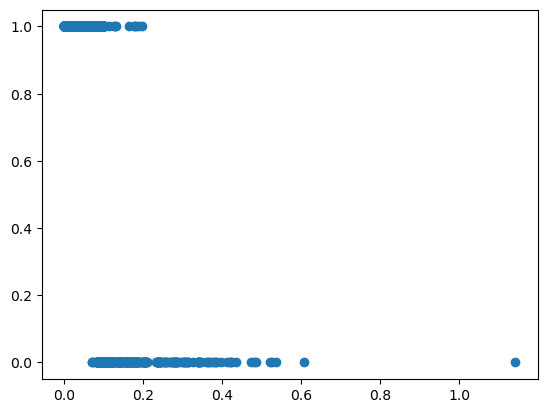

In [34]:
plt.scatter(final_hist['gap_FW'], final_hist['success'])

In [17]:
hist['gap_trans'] = np.exp(-hist['FW_gap'])

In [130]:
hist.groupby('success')['gap_FW'].mean()

success
False    1.417710
True     2.583606
Name: gap_FW, dtype: float64

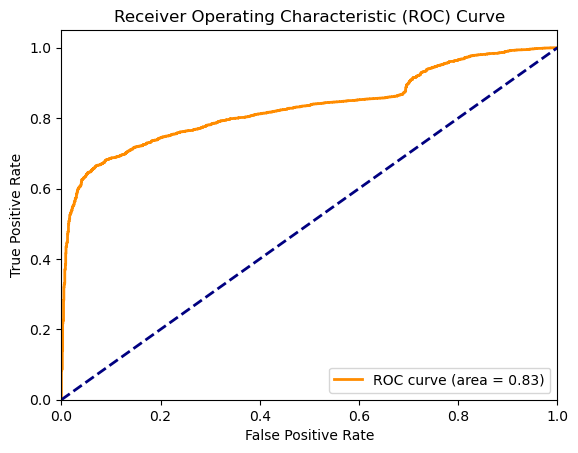

In [23]:
from sklearn.metrics import roc_curve, auc

# Sample data: true binary labels and predicted probabilities
y_true = hist['success']
y_scores = 1- hist['gap_trans']

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

TypeError: Invalid shape (3, 32, 32) for image data

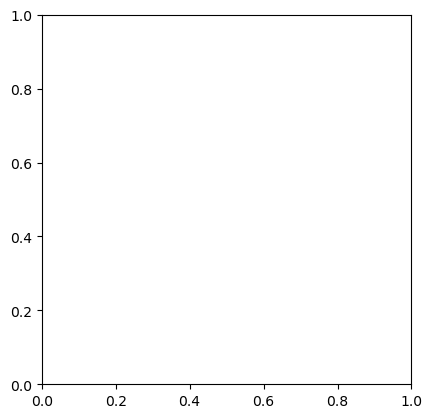

In [4]:
plt.imshow(ex[1][2], cmap='gray')

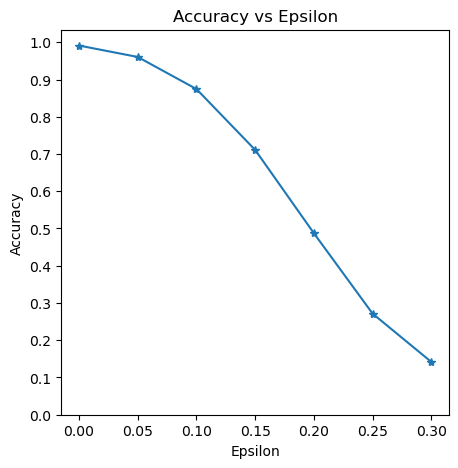

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

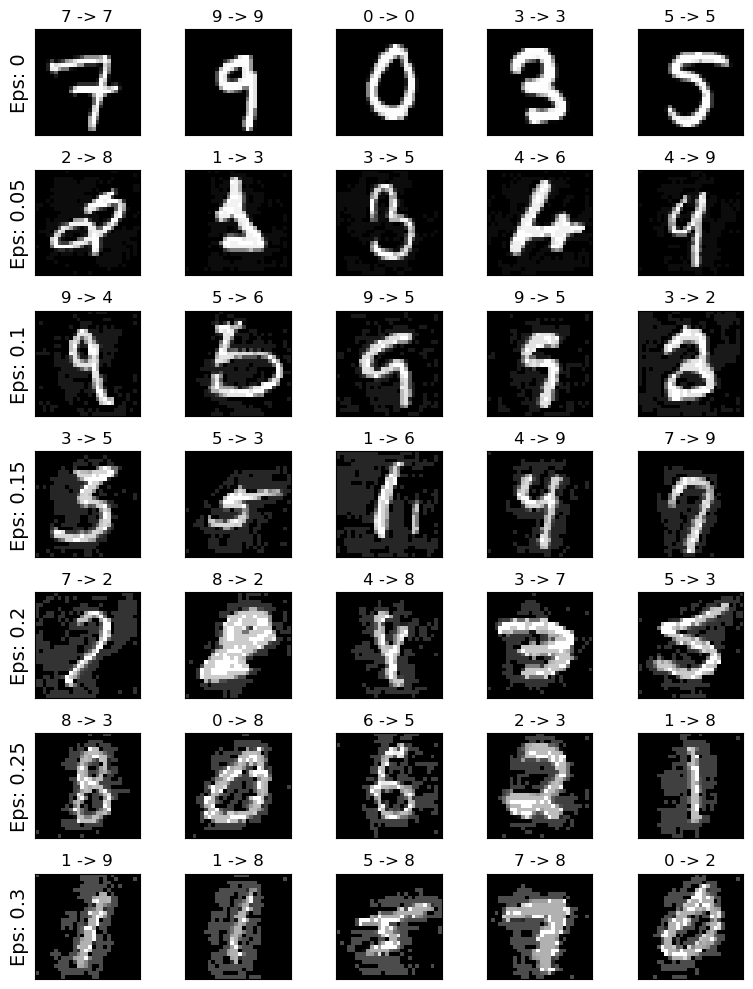

In [18]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()